In [72]:
import numpy as np
from pathlib import Path
from PIL import Image
import cv2
import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt
from patchify import patchify
from tqdm import tqdm

import cloud_utils
from UNet import UNet
from UNet import UNet_no_physical

In [73]:
# Magic command to reload packages whenever we run any later cells.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
testset_path = Path('../../data/38-cloud/38-Cloud_test')
testset_gt_path = testset_path/'Entire_scene_gts'

In [75]:
device = 'cuda:6' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda:6


In [76]:
# Load the saved UNet model
model_path = Path('./model/38-cloud-unet-nophy-ep20-lr0p005.pth')
model = UNet_no_physical(in_channels=4, out_channels=2).to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [77]:
patch_len = 384

In [78]:
# count the number of files in testset_path/'test_gt'
num_files = len(list((testset_path/'test_gt').iterdir()))
print(f'Number of files in test set: {num_files}')

Number of files in test set: 9201


In [79]:
all_test_set = cloud_utils.CloudDataset(
    testset_path/'test_red',
    testset_path/'test_green',
    testset_path/'test_blue',
    testset_path/'test_nir',
	testset_path/'test_gt'
)

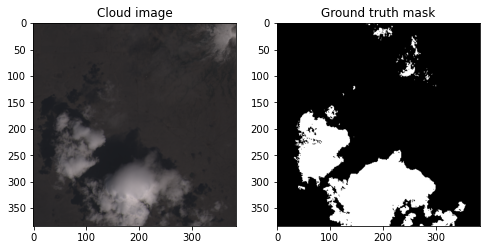

In [80]:
example_id = 6
example_image_no_nir = torch.tensor(all_test_set.open_as_array(example_id))
example_image = all_test_set.open_as_array(example_id, include_nir=True)
example_image = torch.tensor(example_image).unsqueeze(0).permute(0, 3, 1, 2)
exmample_gt_mask = torch.tensor(all_test_set.open_mask(example_id))
cloud_utils.show_one_image_and_mask_info(example_image_no_nir, exmample_gt_mask)

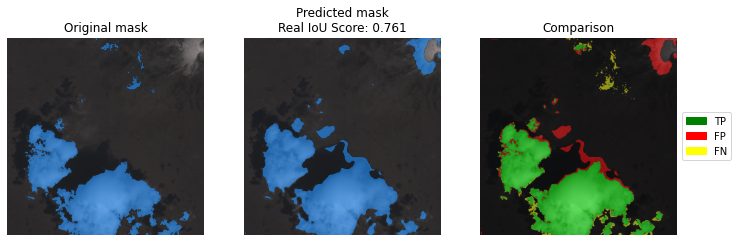

In [81]:
model.eval()
with torch.no_grad():
	exmaple_output = model(example_image.to(device, dtype=torch.float32)).cpu()
	exmaple_pred_mask = F.softmax(exmaple_output[0], 0).argmax(0)
	cloud_utils.show_prediction_results(exmaple_pred_mask, exmample_gt_mask, example_image_no_nir)

In [82]:
# Create a list to store the indices of non-empty images
try:
	non_empty_test_indices = []
	with open('./extra_data/non_empty_test_indices.txt','r') as f:
		for line in f:
			non_empty_test_indices.append(int(line.strip()))
except:
	non_empty_test_indices = [i for i, record in enumerate(all_test_set)
						 if record[0].max() != 0]
	with open('./extra_data/non_empty_test_indices.txt', 'w') as f:
		for i in non_empty_test_indices:
			f.write(str(i) +'\n')

print(f'{len(non_empty_test_indices)} out of {len(all_test_set)} are valid masks in testset.')

6205 out of 9201 are valid masks in testset.


In [83]:
# use the valid indices to filter the all_test_set
test_set = torch.utils.data.Subset(all_test_set, non_empty_test_indices)
BATCH_SIZE = 32
test_dl = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)
print(f'test_set size: {len(test_set)}')
print(f'test_dl size: {len(test_dl)}')

test_set size: 6205
test_dl size: 194


In [84]:
loss_fn = torch.nn.CrossEntropyLoss()
test_loss, test_iou_score, test_precision = 0.0, 0.0, 0.0
test_recall, test_specificity, test_accuracy = 0.0, 0.0, 0.0

model.eval()
with torch.no_grad():
	for batch in tqdm(test_dl, desc='Testing'):
		images_batch, masks_batch = batch
		images_batch = images_batch.to(device=device, dtype=torch.float32)
		masks_batch = masks_batch.to(device=device, dtype=torch.float32)
		outputs = model(images_batch)
		loss = loss_fn(outputs, masks_batch.long())
		test_loss += loss.item()
		iou_score, precision, recall, specificity, accuracy = cloud_utils.compute_all_metrics(outputs, masks_batch)
		test_iou_score += iou_score
		test_precision += precision
		test_recall += recall
		test_specificity += specificity
		test_accuracy += accuracy
	test_loss /= len(test_dl)
	test_iou_score /= len(test_dl)
	test_precision /= len(test_dl)
	test_recall /= len(test_dl)
	test_specificity /= len(test_dl)
	test_accuracy /= len(test_dl)

Testing:   0%|          | 0/194 [00:00<?, ?it/s]

Testing: 100%|██████████| 194/194 [01:34<00:00,  2.05it/s]


In [85]:
print(f'Test loss: {test_loss:.4f}, Test IoU: {test_iou_score:.4f}, '+
      f'Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, '+
      f'Test Specificity: {test_specificity:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test loss: 0.2040, Test IoU: 0.7399, Test Precision: 0.8607, Test Recall: 0.7805, Test Specificity: 0.7031, Test Accuracy: 0.9206


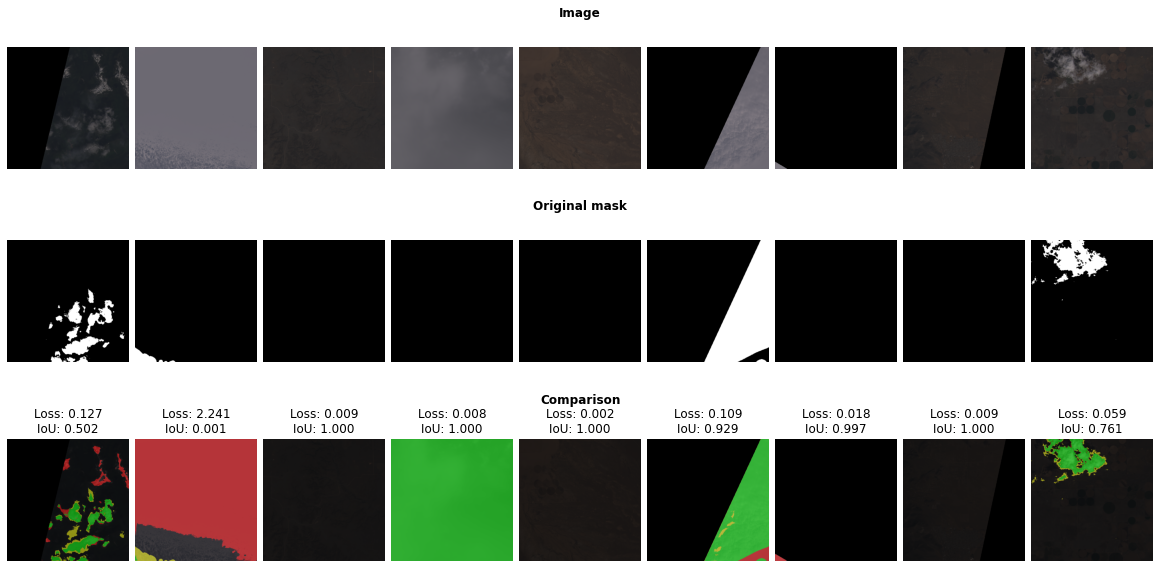

In [87]:
fig = plt.figure(figsize=(16, 8), constrained_layout=True)
subfigs = fig.subfigures(nrows=3, ncols=1)
subfigs[0].suptitle('Image', fontweight='bold')
subfigs[1].suptitle('Original mask', fontweight='bold')
subfigs[2].suptitle('Comparison', fontweight='bold')
ax0 = subfigs[0].subplots(nrows=1, ncols=9)
ax1 = subfigs[1].subplots(nrows=1, ncols=9)
ax2 = subfigs[2].subplots(nrows=1, ncols=9)
for i in range(9):
	image, true_mask = test_set[i+9]
	image_no_nir = image[:3,:,:]
	image_no_nir = image_no_nir.permute(1, 2, 0)
	ax0[i].imshow(image_no_nir)
	ax0[i].axis('off')
	ax1[i].imshow(true_mask, cmap='gray')
	ax1[i].axis('off')
	# only take first 3 channels
	model.eval()
	with torch.no_grad():
		pred_output = model(image.unsqueeze(0).to(device, dtype=torch.float32)).cpu()
		pred_mask = F.softmax(pred_output[0], 0).argmax(0)
		iou = cloud_utils.compute_IoU_per_image(pred_mask, true_mask)
		loss = loss_fn(pred_output, true_mask.unsqueeze(0).long())
		ax2[i].set_title(f"Loss: {loss:.3f}\nIoU: {iou:.3f}")
		cloud_utils.plot_mask_comparison(pred_mask, true_mask, image_no_nir,
								   		 ax2[i], has_legend=False)
		ax2[i].axis('off')